# AutoClave

In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt 
%matplotlib inline
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import LabelEncoder

In [14]:
def value_counts_ratio(col_name, df, target_name='target'):
    """
    주어진 데이터프레임의 특정 열에 대해 각 값마다 타겟 변수의 비율과 갯수, 총 갯수를 출력하는 함수.

    Parameters:
    df (pd.DataFrame): 데이터프레임
    col_name (str): 열 이름
    target_name (str): 타겟 변수 이름
    """
    # 각 값마다 타겟 변수의 비율 계산
    value_counts = df.groupby(col_name)[target_name].value_counts(normalize=True).unstack().fillna(0)
    
    # 각 값마다 타겟 변수의 갯수 계산
    counts = df.groupby(col_name)[target_name].value_counts().unstack().fillna(0)
    
    # 각 값마다 총 갯수 계산
    total_counts = df[col_name].value_counts().rename('Total_Count')
    
    # 비율과 갯수를 합침
    result = value_counts.join(counts, lsuffix='_ratio', rsuffix='_count')
    
    # 총 갯수를 합침
    result = result.join(total_counts, on=col_name)
    
    # 출력 형식 조정
    result.index.name = 'variable'
    print(f"\n{col_name}별 {target_name} 비율 및 갯수\n")
    print(result.rename(columns=lambda x: x.split('_')[0]))

In [15]:
### 한글 및 부호 깨짐 방지
plt.rcParams['font.family'] = 'AppleGothic' #한글
mpl.rcParams['axes.unicode_minus'] = False #마이너스 부호

In [16]:
# csv 불러오기
train_data = pd.read_csv('trim_train_data.csv')

In [17]:
# '_AutoClave'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='_AutoClave').columns

# 필터링된 열 이름 출력
print("<AutoClave 공정 관련 변수>")
for col in Process_Desc_col:
    print(col)

<AutoClave 공정 관련 변수>
Wip Line_AutoClave
Process Desc._AutoClave
Equipment_AutoClave
Model.Suffix_AutoClave
Workorder_AutoClave
Insp. Seq No._AutoClave
Insp Judge Code_AutoClave
1st Pressure Collect Result_AutoClave
1st Pressure 1st Pressure Unit Time_AutoClave
1st Pressure Judge Value_AutoClave
2nd Pressure Collect Result_AutoClave
2nd Pressure Unit Time_AutoClave
2nd Pressure Judge Value_AutoClave
3rd Pressure Collect Result_AutoClave
3rd Pressure Unit Time_AutoClave
3rd Pressure Judge Value_AutoClave
Chamber Temp. Collect Result_AutoClave
Chamber Temp. Unit Time_AutoClave
Chamber Temp. Judge Value_AutoClave
GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave
GMES_ORIGIN_INSP_JUDGE_CODE Unit Time_AutoClave
GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave


In [35]:
# 고윳값 확인
for col in Process_Desc_col:
    cnt = train_data[col].value_counts()
    print(f"{cnt}\n")

Wip Line_AutoClave
IVI-OB6    40506
Name: count, dtype: int64

Process Desc._AutoClave
Auto Clave Out    40506
Name: count, dtype: int64

Equipment_AutoClave
Auto Clave Out    40506
Name: count, dtype: int64

Model.Suffix_AutoClave
AJX75334501    33820
AJX75334502     3390
AJX75334505     2635
AJX75334507      310
AJX75334503      162
AJX75334506      129
AJX75334508       60
Name: count, dtype: int64

Workorder_AutoClave
3L1X8574-2       272
3K1XC268-1       227
3L1X9934-1       217
3L1X8506-1       217
3K1XA586-2       189
                ... 
4BPM0084-1         2
3FPXX064-0003      2
3H1XB714-1         1
4CPM0166-1         1
3HPM0061-1         1
Name: count, Length: 663, dtype: int64

Insp. Seq No._AutoClave
1    40506
Name: count, dtype: int64

Insp Judge Code_AutoClave
OK    40506
Name: count, dtype: int64

1st Pressure Collect Result_AutoClave
0.311    2932
0.310    2723
0.301    2705
0.312    2631
0.309    2586
0.313    2423
0.302    2311
0.300    2308
0.308    2281
0.314    227

### pressure & unit time

In [19]:
# 각 압력과 시간의 곱을 담은 새로운 컬럼 생성
train_data['1st_pressure_time_AutoClave'] = train_data['1st Pressure Collect Result_AutoClave'] * train_data['1st Pressure 1st Pressure Unit Time_AutoClave']
train_data['2nd_pressure_time_AutoClave'] = train_data['2nd Pressure Collect Result_AutoClave'] * train_data['2nd Pressure Unit Time_AutoClave']
train_data['3rd_pressure_time_AutoClave'] = train_data['3rd Pressure Collect Result_AutoClave'] * train_data['3rd Pressure Unit Time_AutoClave']

train_data['avg_pressure_time_AutoClave'] = (train_data['1st_pressure_time_AutoClave'] +
                                             train_data['2nd_pressure_time_AutoClave'] +
                                             train_data['3rd_pressure_time_AutoClave']) / 3

In [22]:
train_data['avg_pressure_time_AutoClave'].describe()

count    40506.000000
mean        51.955199
std          7.131959
min          0.315000
25%         44.963667
50%         53.610000
75%         57.492667
max         89.153333
Name: avg_pressure_time_AutoClave, dtype: float64

In [26]:
# 구간 정의 (10개의 구간)
min_value = train_data['avg_pressure_time_AutoClave'].min()
max_value = train_data['avg_pressure_time_AutoClave'].max()
bins = np.linspace(min_value, max_value, num=11)  # 0.32 ~ 89.15를 10개의 구간으로 나누기
labels = [f'구간 {i+1}' for i in range(len(bins)-1)]

# 구간 나누기
train_data['avg_pressure_time_label_AutoClave'] = pd.cut(train_data['avg_pressure_time_AutoClave'], bins=bins, labels=labels, include_lowest=True)

In [30]:
# 각 구간의 최소값과 최대값 계산
intervals = pd.DataFrame({
    '구간': labels,
    '최소값': [bins[i] for i in range(len(bins)-1)],
    '최대값': [bins[i+1] for i in range(len(bins)-1)]
})

# 결과 출력
print(intervals)

      구간        최소값        최대값
0   구간 1   0.315000   9.198833
1   구간 2   9.198833  18.082667
2   구간 3  18.082667  26.966500
3   구간 4  26.966500  35.850333
4   구간 5  35.850333  44.734167
5   구간 6  44.734167  53.618000
6   구간 7  53.618000  62.501833
7   구간 8  62.501833  71.385667
8   구간 9  71.385667  80.269500
9  구간 10  80.269500  89.153333


In [29]:
value_counts_ratio('avg_pressure_time_label_AutoClave', train_data)


avg_pressure_time_label_AutoClave별 target 비율 및 갯수

          AbNormal    Normal  AbNormal  Normal  Total
variable                                             
구간 1      0.000000  1.000000         0       4      4
구간 2      1.000000  0.000000         2       0      2
구간 3      0.693878  0.306122        34      15     49
구간 4      0.000000  1.000000         0       1      1
구간 5      0.050872  0.949128       394    7351   7745
구간 6      0.046977  0.953023       585   11868  12453
구간 7      0.061971  0.938029      1054   15954  17008
구간 8      0.086795  0.913205       280    2946   3226
구간 9      0.076923  0.923077         1      12     13
구간 10     0.000000  1.000000         0       5      5


/var/folders/c6/kvlszyfj2q9_tv_8pb0y40qm0000gn/T/ipykernel_23049/114059916.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  value_counts = df.groupby(col_name)[target_name].value_counts(normalize=True).unstack().fillna(0)
/var/folders/c6/kvlszyfj2q9_tv_8pb0y40qm0000gn/T/ipykernel_23049/114059916.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df.groupby(col_name)[target_name].value_counts().unstack().fillna(0)


/var/folders/c6/kvlszyfj2q9_tv_8pb0y40qm0000gn/T/ipykernel_23049/2065307476.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_df = train_data.groupby(['avg_pressure_time_label_AutoClave', 'target']).size().unstack(fill_value=0)


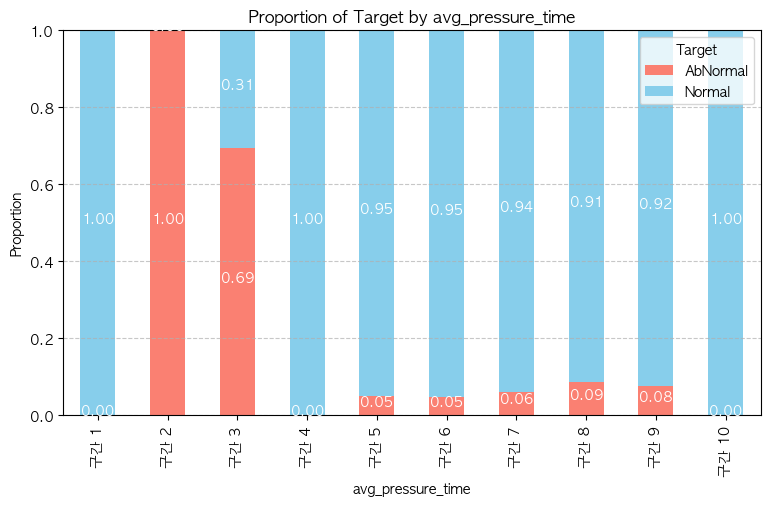

In [28]:
### avg_pressure_time에 따른 타깃값

# 비율 계산
count_df = train_data.groupby(['avg_pressure_time_label_AutoClave', 'target']).size().unstack(fill_value=0)
count_df = count_df.div(count_df.sum(axis=1), axis=0)

# 비율 시각화
count_df.plot(kind='bar', stacked=True, color=['salmon', 'skyblue'], figsize=(9, 5))

plt.xlabel('avg_pressure_time')
plt.ylabel('Proportion')
plt.title('Proportion of Target by avg_pressure_time')
plt.legend(title='Target', loc='upper right')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 그래프 위에 비율 표시
for i in range(count_df.shape[0]):
    for j in range(count_df.shape[1]):
        plt.text(i, count_df.iloc[i, j] / 2 + count_df.iloc[i, :j].sum(), f"{count_df.iloc[i, j]:.2f}", ha='center', color='white')

plt.show()

### chamber temp & unit time

In [49]:
value_counts_ratio('Chamber Temp. Collect Result_AutoClave', train_data)


Chamber Temp. Collect Result_AutoClave별 target 비율 및 갯수

          AbNormal    Normal  AbNormal  Normal  Total
variable                                             
32        0.565217  0.434783      13.0    10.0     23
33        0.000000  1.000000       0.0     4.0      4
34        1.000000  0.000000       2.0     0.0      2
35        0.250000  0.750000       1.0     3.0      4
36        0.060606  0.939394       2.0    31.0     33
37        0.000000  1.000000       0.0     6.0      6
38        0.000000  1.000000       0.0     6.0      6
40        0.000000  1.000000       0.0     3.0      3
42        1.000000  0.000000       1.0     0.0      1
43        0.200000  0.800000       4.0    16.0     20
44        0.000000  1.000000       0.0     3.0      3
45        0.081081  0.918919       3.0    34.0     37
46        0.098404  0.901596      37.0   339.0    376
47        0.059877  0.940123     107.0  1680.0   1787
48        0.051389  0.948611     172.0  3175.0   3347
49        0.056203  0.943

In [51]:
train_data['chamber_temp_time_AutoClave'] = train_data['Chamber Temp. Collect Result_AutoClave'] * train_data['Chamber Temp. Unit Time_AutoClave']
train_data['chamber_temp_time_AutoClave'].describe()

count    40506.000000
mean     21921.554041
std       3402.621983
min        147.000000
25%      19133.000000
50%      22560.000000
75%      25088.000000
max      31320.000000
Name: chamber_temp_time_AutoClave, dtype: float64

In [70]:
# 구간 정의
min_value = train_data['chamber_temp_time_AutoClave'].min()
max_value = train_data['chamber_temp_time_AutoClave'].max()
bins = np.linspace(min_value, max_value, num=31)
labels = [f'구간 {i+1}' for i in range(len(bins)-1)]

# 구간 나누기
train_data['chamber_temp_time_label_AutoClave'] = pd.cut(train_data['chamber_temp_time_AutoClave'], bins=bins, labels=labels, include_lowest=True)
value_counts_ratio('chamber_temp_time_label_AutoClave', train_data)


chamber_temp_time_label_AutoClave별 target 비율 및 갯수

          AbNormal    Normal  AbNormal  Normal  Total
variable                                             
구간 1      0.000000  1.000000         0       4      4
구간 2      0.000000  0.000000         0       0      0
구간 3      0.000000  0.000000         0       0      0
구간 4      1.000000  0.000000         2       0      2
구간 5      0.000000  0.000000         0       0      0
구간 6      0.928571  0.071429        13       1     14
구간 7      0.000000  0.000000         0       0      0
구간 8      0.000000  0.000000         0       0      0
구간 9      1.000000  0.000000         6       0      6
구간 10     0.500000  0.500000         3       3      6
구간 11     0.500000  0.500000        12      12     24
구간 12     0.080000  0.920000         2      23     25
구간 13     0.000000  1.000000         0      31     31
구간 14     0.117647  0.882353         2      15     17
구간 15     0.155556  0.844444         7      38     45
구간 16     0.103774  0.896226  

/var/folders/c6/kvlszyfj2q9_tv_8pb0y40qm0000gn/T/ipykernel_23049/114059916.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  value_counts = df.groupby(col_name)[target_name].value_counts(normalize=True).unstack().fillna(0)
/var/folders/c6/kvlszyfj2q9_tv_8pb0y40qm0000gn/T/ipykernel_23049/114059916.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df.groupby(col_name)[target_name].value_counts().unstack().fillna(0)


/var/folders/c6/kvlszyfj2q9_tv_8pb0y40qm0000gn/T/ipykernel_23049/3002503512.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_df = train_data.groupby(['chamber_temp_time_label_AutoClave', 'target']).size().unstack(fill_value=0)
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
po

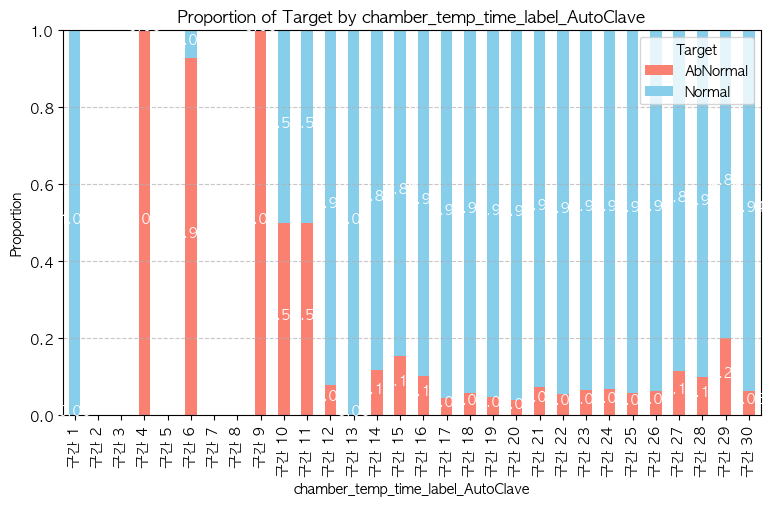

In [71]:
### chamber_temp_time_label_AutoClave에 따른 타깃값

# 비율 계산
count_df = train_data.groupby(['chamber_temp_time_label_AutoClave', 'target']).size().unstack(fill_value=0)
count_df = count_df.div(count_df.sum(axis=1), axis=0)

# 비율 시각화
count_df.plot(kind='bar', stacked=True, color=['salmon', 'skyblue'], figsize=(9, 5))

plt.xlabel('chamber_temp_time_label_AutoClave')
plt.ylabel('Proportion')
plt.title('Proportion of Target by chamber_temp_time_label_AutoClave')
plt.legend(title='Target', loc='upper right')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 그래프 위에 비율 표시
for i in range(count_df.shape[0]):
    for j in range(count_df.shape[1]):
        plt.text(i, count_df.iloc[i, j] / 2 + count_df.iloc[i, :j].sum(), f"{count_df.iloc[i, j]:.2f}", ha='center', color='white')

plt.show()

### unit time

In [59]:
train_data['sum_unit_time'] = train_data['1st Pressure 1st Pressure Unit Time_AutoClave'] + train_data['2nd Pressure Unit Time_AutoClave'] + train_data['3rd Pressure Unit Time_AutoClave']
train_data['same_unit_time'] = train_data['Chamber Temp. Unit Time_AutoClave'] == train_data['sum_unit_time']

In [60]:
train_data['same_unit_time'].value_counts()

same_unit_time
True    40506
Name: count, dtype: int64

In [61]:
train_data['sum_unit_time'].describe()

count    40506.000000
mean       423.985212
std         61.066771
min          3.000000
25%        363.000000
50%        452.000000
75%        483.000000
max        540.000000
Name: sum_unit_time, dtype: float64

In [63]:
value_counts_ratio('sum_unit_time', train_data)


sum_unit_time별 target 비율 및 갯수

          AbNormal    Normal  AbNormal   Normal  Total
variable                                              
3         0.000000  1.000000       0.0      4.0      4
61        1.000000  0.000000       2.0      0.0      2
121       0.000000  1.000000       0.0      1.0      1
180       1.000000  0.000000       6.0      0.0      6
183       1.000000  0.000000      13.0      0.0     13
212       0.500000  0.500000      12.0     12.0     24
242       0.500000  0.500000       3.0      3.0      6
243       0.000000  1.000000       0.0      9.0      9
300       0.214286  0.785714       3.0     11.0     14
301       0.137931  0.862069       4.0     25.0     29
303       0.090909  0.909091       1.0     10.0     11
360       0.050279  0.949721       9.0    170.0    179
361       0.050254  0.949746     198.0   3742.0   3940
362       0.063291  0.936709      25.0    370.0    395
363       0.047702  0.952298     708.0  14134.0  14842
423       0.000000  1.000000     

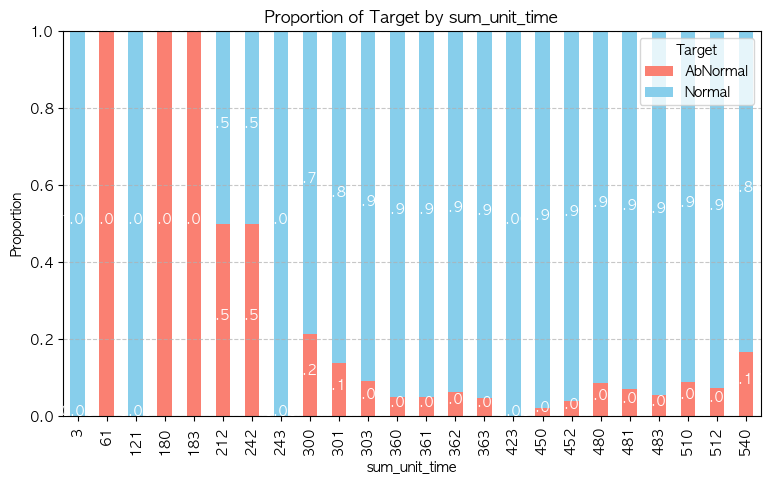

In [64]:
### sum_unit_time에 따른 타깃값

# 비율 계산
count_df = train_data.groupby(['sum_unit_time', 'target']).size().unstack(fill_value=0)
count_df = count_df.div(count_df.sum(axis=1), axis=0)

# 비율 시각화
count_df.plot(kind='bar', stacked=True, color=['salmon', 'skyblue'], figsize=(9, 5))

plt.xlabel('sum_unit_time')
plt.ylabel('Proportion')
plt.title('Proportion of Target by sum_unit_time')
plt.legend(title='Target', loc='upper right')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 그래프 위에 비율 표시
for i in range(count_df.shape[0]):
    for j in range(count_df.shape[1]):
        plt.text(i, count_df.iloc[i, j] / 2 + count_df.iloc[i, :j].sum(), f"{count_df.iloc[i, j]:.2f}", ha='center', color='white')

plt.show()

### dam ~ autoclave 공정 총 소요시간

In [65]:
# total_tact_time
train_data['total_tact_time'] = (train_data['Machine Tact time Collect Result_Dam'] + 
                                     train_data['Machine Tact time Collect Result_Fill1'] +
                                     train_data['Machine Tact time Collect Result_Fill2'])

train_data['total_time'] = train_data['total_tact_time'] + train_data['sum_unit_time']

In [67]:
train_data['total_time'].describe()

count    40506.000000
mean       578.783815
std         80.818947
min        201.100000
25%        498.000000
50%        608.300000
75%        650.200000
max       1585.700000
Name: total_time, dtype: float64

In [73]:
# 구간 정의
min_value = train_data['total_time'].min()
max_value = train_data['total_time'].max()
bins = np.linspace(min_value, max_value, num=31)
labels = [f'구간 {i+1}' for i in range(len(bins)-1)]

# 구간 나누기
train_data['total_time_label_AutoClave'] = pd.cut(train_data['total_time'], bins=bins, labels=labels, include_lowest=True)
value_counts_ratio('total_time_label_AutoClave', train_data)


total_time_label_AutoClave별 target 비율 및 갯수

          AbNormal    Normal  AbNormal  Normal  Total
variable                                             
구간 1      0.333333  0.666667         2       4      6
구간 2      0.000000  1.000000         0       1      1
구간 3      1.000000  0.000000        18       0     18
구간 4      0.382353  0.617647        13      21     34
구간 5      0.500000  0.500000         1       1      2
구간 6      0.119403  0.880597         8      59     67
구간 7      0.048212  0.951788       929   18340  19269
구간 8      0.089286  0.910714        10     102    112
구간 9      0.046741  0.953259       223    4548   4771
구간 10     0.051431  0.948569       363    6695   7058
구간 11     0.082885  0.917115       616    6816   7432
구간 12     0.095597  0.904403       165    1561   1726
구간 13     0.000000  1.000000         0       3      3
구간 14     0.333333  0.666667         1       2      3
구간 15     0.000000  1.000000         0       2      2
구간 16     0.000000  0.000000         

/var/folders/c6/kvlszyfj2q9_tv_8pb0y40qm0000gn/T/ipykernel_23049/114059916.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  value_counts = df.groupby(col_name)[target_name].value_counts(normalize=True).unstack().fillna(0)
/var/folders/c6/kvlszyfj2q9_tv_8pb0y40qm0000gn/T/ipykernel_23049/114059916.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df.groupby(col_name)[target_name].value_counts().unstack().fillna(0)


/var/folders/c6/kvlszyfj2q9_tv_8pb0y40qm0000gn/T/ipykernel_23049/880826597.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_df = train_data.groupby(['total_time_label_AutoClave', 'target']).size().unstack(fill_value=0)
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and p

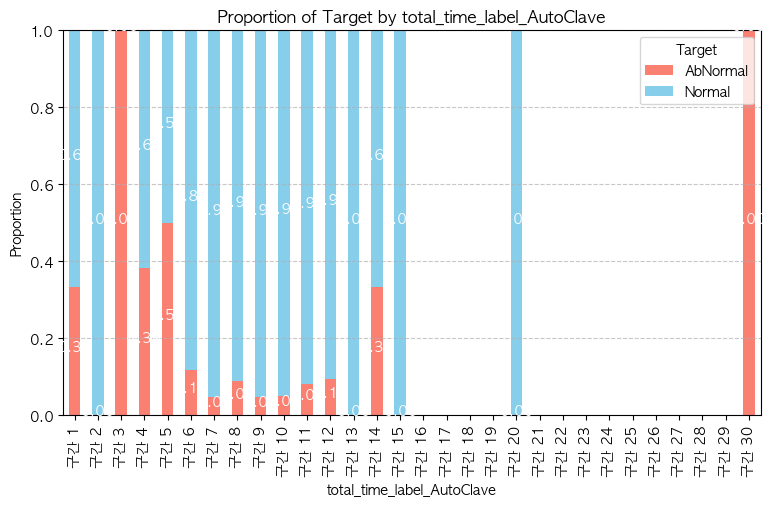

In [74]:
### sum_unit_time에 따른 타깃값

# 비율 계산
count_df = train_data.groupby(['total_time_label_AutoClave', 'target']).size().unstack(fill_value=0)
count_df = count_df.div(count_df.sum(axis=1), axis=0)

# 비율 시각화
count_df.plot(kind='bar', stacked=True, color=['salmon', 'skyblue'], figsize=(9, 5))

plt.xlabel('total_time_label_AutoClave')
plt.ylabel('Proportion')
plt.title('Proportion of Target by total_time_label_AutoClave')
plt.legend(title='Target', loc='upper right')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 그래프 위에 비율 표시
for i in range(count_df.shape[0]):
    for j in range(count_df.shape[1]):
        plt.text(i, count_df.iloc[i, j] / 2 + count_df.iloc[i, :j].sum(), f"{count_df.iloc[i, j]:.2f}", ha='center', color='white')

plt.show()